In [80]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from statsmodels.nonparametric.kernel_regression import KernelReg
import yfinance as yf
from datetime import datetime, timedelta
from backtester import *
from pandas.tseries.offsets import *
import operator
import warnings
warnings.filterwarnings("ignore")

In [81]:
import sys
sys.path.insert(0, 'price_action_strategies')
sys.path.insert(0, 'price_action_strategies/IHS&HS')
from find_extrema_file import *
from backtester import *
from head_and_shoulders import *

In [2]:
def find_extrema(s, bw='cv_ls'):
    """
    Input:
        s: prices as pd.series
        bw: bandwith as str or array like
    Returns:
        prices: with 0-based index as pd.series
        extrema: extrema of prices as pd.series
        smoothed_prices: smoothed prices using kernel regression as pd.series
        smoothed_extrema: extrema of smoothed_prices as pd.series
    """
    # Copy series so we can replace index and perform non-parametric
    # kernel regression.
    prices = s.copy()
    prices = prices.reset_index()
    prices.columns = ['date', 'price']
    prices = prices['price']

    kr = KernelReg(
        [prices.values],
        [prices.index.to_numpy()],
        var_type='c', bw=bw
    )
    f = kr.fit([prices.index])

    # Use smoothed prices to determine local minima and maxima
    smooth_prices = pd.Series(data=f[0], index=prices.index)
    smooth_local_max = argrelextrema(smooth_prices.values, np.greater)[0]
    smooth_local_min = argrelextrema(smooth_prices.values, np.less)[0]
    local_max_min = np.sort(
        np.concatenate([smooth_local_max, smooth_local_min]))
    smooth_extrema = smooth_prices.loc[local_max_min]

    # Iterate over extrema arrays returning datetime of passed
    # prices array. Uses idxmax and idxmin to window for local extrema.
    price_local_max_dt = []
    for i in smooth_local_max:
        if (i > 1) and (i < len(prices)-1):
            price_local_max_dt.append(prices.iloc[i-2:i+2].idxmax())

    price_local_min_dt = []
    for i in smooth_local_min:
        if (i > 1) and (i < len(prices)-1):
            price_local_min_dt.append(prices.iloc[i-2:i+2].idxmin())

    maxima = pd.Series(prices.loc[price_local_max_dt])
    minima = pd.Series(prices.loc[price_local_min_dt])
    extrema = pd.concat([maxima, minima]).sort_index()

    # Return series for each with bar as index
    return extrema, prices, smooth_extrema, smooth_prices

In [17]:
def head_and_shoulders(extrema):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        dates: list of dates containing the start and end bar of the pattern
    """

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)+1):
        window = extrema.iloc[i-5:i]

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        rtop_g1 = np.mean([e1, e3, e5])
        rtop_g2 = np.mean([e2, e4])

        # Head and Shoulders
        if (e1 > e2) and (e3 > e1) and (e3 > e5) and \
                (abs(e1 - e5) <= 0.03*np.mean([e1, e5])) and \
                (abs(e2 - e4) <= 0.03*np.mean([e1, e5])):

            return [e1, e2, e3, e4, e5]

    return 

def inverse_head_and_shoulders(extrema):
    """
    Input:
        extrema: extrema as pd.series with bar number as index
        max_bars: max bars for pattern to play out
    Returns:
        dates: list of dates containing the start and end bar of the pattern
    """

    # Need to start at five extrema for pattern generation
    for i in range(5, len(extrema)+1):
        window = extrema.iloc[i-5:i]

        # Using the notation from the paper to avoid mistakes
        e1 = window.iloc[0]
        e2 = window.iloc[1]
        e3 = window.iloc[2]
        e4 = window.iloc[3]
        e5 = window.iloc[4]

        # Inverse Head and Shoulders
        if (e1 < e2) and (e3 < e1) and (e3 < e5) and \
             (abs(e1 - e5) <= 0.03 * np.mean([e1, e5])) and \
             (abs(e2 - e4) <= 0.03 * np.mean([e1, e5])):
            
            return [e1, e2, e3, e4, e5]

    return

In [64]:
def format_strategy_data(data, strategy, max_bars, signal_type, pos_target):
    
    # initialising lists to store output variables
    detection_dates = []
    price_points = [[0, 1, 2, 3, 4]]
    entry_points = []
    entry_dates = []
    stoploss = []

    for i in range(0, len(data)):

            # indexing the prices of interest
            prices = data["Close"][i:i+max_bars]

            # finding the extrema
            extrema, _, _, _ = find_extrema(prices, bw=[0.85])

            # only run head and shoulders when there are 5 extrema
            if len(extrema) >= 5:  

                # detecting the extrema of the input strategy
                e = strategy(extrema)

            # on the first appendment to the strategy detection variable lists
            if e is not None:
                
                check = np.array(price_points[-1]) - np.array(e)
                
                if np.count_nonzero(check==0) == 0: # ensures no duplicate patterns
                    
                    detection_dates.append(prices.index[-1])
                    price_points.append(e)

                    if signal_type == "bearish":
                        nxt_10_days = data.loc[prices.index[-1]:prices.index[-1]+timedelta(days=10)].Close.le(min(e))
                        entry_points.append(min(e))
                        stoploss.append(max(e))
                        op = operator.sub

                    elif signal_type == "bullish":
                        nxt_10_days = data.loc[prices.index[-1]:prices.index[-1]+timedelta(days=10)].Close.ge(max(e))
                        entry_points.append(max(e))
                        stoploss.append(min(e))
                        op = operator.add

                    if len(nxt_10_days[nxt_10_days == True]) != 0:
                        val = nxt_10_days[nxt_10_days == True].idxmin()
                        entry_dates.append(val)
                        
                    else:
                        entry_dates.append("No Entry")
                        
    return detection_dates, price_points[1:], entry_points, entry_dates, stoploss, op


def create_strategy_df(data, detection_dates, entry_dates, stoploss, pos_target, op):
    
    # initialising strategy variables in dataframe  
    data = data[["Open", "High", "Low", "Close", "Volume"]]
    data["PatternDetected"] = 0
    data["Entry"] = 0
    data["StopLoss"] = 0
    data["PosTarget"] = 0 
    
    # creating values at relevant entry points
    
    for i in range(0, len(entry_dates)):
        
        if type(entry_dates[i]) != str:
            data.loc[detection_dates[i], "PatternDetected"] = 1
            data.loc[entry_dates[i], "Entry"] = 1
            data.loc[entry_dates[i], "StopLoss"] = stoploss[i]
            data.loc[entry_dates[i], "PosTarget"] = data.loc[entry_dates[i] + BDay(1)]["Open"] * op(1, pos_target)
        
        
    return data

In [74]:
lite = yf.Ticker("LITE").history(period="30y")
max_bars = 35
signal_type = "bearish"
pos_target = 0.05

detection_dates, price_points, entry_points, entry_dates, stoploss, opper = format_strategy_data(lite, head_and_shoulders, max_bars, signal_type, pos_target)
lite = create_strategy_df(lite, detection_dates, entry_dates, stoploss, pos_target, opper)
lite[lite["Entry"] == 1]

,Open,High,Low,Close,Volume,PatternDetected,Entry,StopLoss,PosTarget
Date,,,,,,,,,
2016-04-18,26.830000,27.049999,25.610001,25.940001,521600,1,1,27.459999,24.576501
2016-10-27,40.799999,41.500000,38.500000,38.900002,2157400,0,1,44.500000,35.625000
2017-08-04,61.599998,62.349998,58.099998,58.849998,2878000,0,1,67.949997,57.000000
2018-04-23,59.549999,60.099998,53.500000,54.450001,5555600,0,1,64.300003,52.059999
2018-05-24,63.000000,63.299999,61.599998,62.299999,851000,1,1,64.500000,59.232499
2018-10-04,60.830002,61.000000,58.790001,59.360001,1134200,1,1,63.150002,55.955001
2021-01-29,97.320000,97.970001,93.410004,93.800003,1589900,0,1,108.930000,91.067001
2021-06-18,80.839996,81.250000,79.720001,80.019997,1008200,0,1,81.940002,76.493997
2021-07-15,82.449997,82.794998,80.570000,81.330002,537000,0,1,83.980003,77.254000


In [76]:
class Head_and_Shoulders(Backtest_Environment):
    
    # first line of arguments contains strategy specific parameters, second line contains backtest environment parameters
    def __init__(self, data, start_date, end_date,
                 start_cash, pos_size, tc, cooldown=1, 
                 max_executions=None, max_execution_period=None, cash_buffer=0, stoploss=None, trailing_stoploss=False, custom_stoploss=False):
        """
        Constructor method for the strategy child class. Extra arguments specific to the child can be added to this 
        constructor.
        
        The benefit of this is that, strategy specific parameters can be added to this class with the data preparation 
        methods occurring within the class prior to backtest(). 
        
        This structure allows for an easier defintion of new strategies for strategies with the similar rule structures
        but different parameters applied to those rules. 
        """
        
        # Calling the constructor of the parent class - stores input variables + adds strategy agnostic columns to the data
        super().__init__(data, start_cash, pos_size, tc, cooldown, max_executions, max_execution_period, cash_buffer, stoploss, trailing_stoploss, custom_stoploss)

        # Strategy specific parameters
        self.start_date = start_date
        self.end_date = end_date
        
    
    def process(self, data):
    
        if data.Entry.values[0] == 1:
            num_units = int(np.floor((self.pos_size * self.cash_available) / data.Close.values[0]))

            if num_units == 0:
                        return 0

             # cash check - acts as a lid on opening new positions
            if (self.cash_available - num_units*data.Close.values[0]) > self.cash_buffer:
                
                return num_units, "Short"

            else:
                return 0

        return 0


    def monitorPosition(self, data, position):
    
        if data.Close.values[0] <= position.PosTarget.values[0]:

            return True

        elif data.Close.values[0] >= position.StopLoss.values[0] or data.High.values[0] >= position.StopLoss.values[0]:

            return True

        else:

            return False

In [77]:
strat = Head_and_Shoulders(lite, lite.index[0], lite.index[-1],
                         start_cash=1000, pos_size=1, tc=0.005, cooldown=0, 
                         max_executions=None, max_execution_period=None, cash_buffer=0, custom_stoploss=True)
strat.backtest()

True

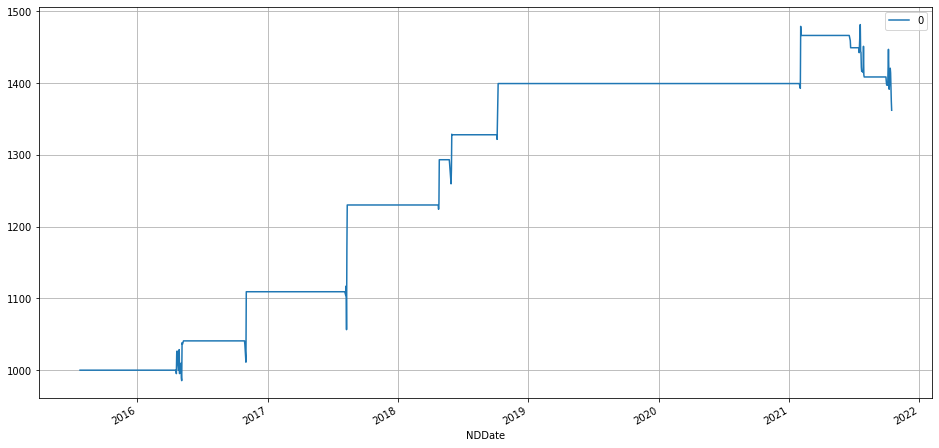

In [78]:
strat.portfolio_time_series.plot(figsize=(16,8))
plt.grid()
plt.show()

In [68]:
strat.stats.T

,0
Initial Capital,1.000000e+03
Ending Capital,1.385098e+03
Total Profit,3.850981e+02
Total Profit Percentage,3.850981e-01
Exposure,2.000000e-02
Annual Return,5.368058e-02
Annual Sharpe Ratio,5.870000e-01
Annual Sortino Ratio,2.500000e-01
Transaction Costs,1.184484e+02
Portfolio Max DD Value,1.590090e+02


In [69]:
strat.positions

,Status,PosType,PosID,Units,EntryPrice,EntryDate,PosTarget,StopLoss,PosVal,ExitPrice,ExitDate,CashGainLoss,PercGainPreTC,WinLoss,Max DD Value,Max DD Return,Holding Time
0,False,Short,185,38,25.590405,2016-04-19,24.576501,27.459999,972.435383,24.458379,2016-05-09,43.016983,0.044236,1.0,1.332,-0.050,20
0,False,Short,320,26,37.555689,2016-10-28,35.625000,44.500000,976.447904,33.652204,2016-11-01,101.490612,0.103939,1.0,0.000,0.000,4
0,False,Short,513,19,59.778419,2017-08-07,57.000000,67.949997,1135.789953,52.486801,2017-08-11,138.540735,0.121977,1.0,5.673,-0.095,4
0,False,Short,692,23,54.582150,2018-04-24,52.059999,64.300003,1255.389442,51.059741,2018-04-26,81.015402,0.064534,1.0,0.000,0.000,2
0,False,Short,715,21,62.817511,2018-05-25,59.232499,64.500000,1319.167739,59.006527,2018-06-01,80.030681,0.060668,1.0,0.150,-0.002,7
0,False,Short,807,23,58.285024,2018-10-05,55.955001,63.150002,1340.555550,54.746505,2018-10-08,81.385941,0.060711,1.0,0.000,0.000,3
0,False,Short,1390,15,96.066743,2021-02-01,91.067001,108.930000,1441.001146,90.746534,2021-02-03,79.803143,0.055380,1.0,0.000,0.000,2
0,False,Short,1487,19,79.342138,2021-06-21,76.493997,81.940002,1507.500620,80.521565,2021-06-22,-22.409118,-0.014865,-1.0,0.000,0.000,1
0,False,Short,1505,18,80.971274,2021-07-16,77.254000,83.980003,1457.482923,82.577652,2021-07-30,-28.914809,-0.019839,-1.0,4.094,-0.050,14


# Example of the code running retrospectively 
- This is useful for studying the behaviour of the asset and identifying common patterns

In [ ]:
extrema, prices, smooth_extrema, smooth_prices = find_extrema(lite["Close"], bw=[0.85])
patterns = find_patterns(extrema, max_bars=35)
#plt.plot(prices)
#plt.scatter(extrema.index, extrema, color="red")
patterns